<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Multimodal RAG with Document Retrieval (ColPali), Amazon Nova and CrewAI
</h1>.

![Agentic RAG](./Multimodal-RAG.png)

In [1]:
# %pip install colpali-engine torch boto3 tqdm pymupdf numpy matplotlib einops seaborn -q
# %pip install boto3==1.34.162 botocore==1.34.162 crewai==0.70.1 crewai_tools==0.12.1 duckduckgo-search==6.3.1 PyPDF2==3.0.1 -q 

In [2]:
import os
import torch
import qdrant_client
import time
import shutil
import boto3
import os

from huggingface_hub import login
from colpali_engine.models import ColPali, ColPaliProcessor
from pdf2image import convert_from_path
from qdrant_client.http import models
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
from crewai import Agent, Task, Crew, LLM, Process
from crewai_tools import tool
from IPython.display import Markdown

/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/pydantic/_internal/_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Loading the PDF files (Dataset)
</h1>

In [3]:
# Create a directory to save the PDF files 
pdf_dir = "pdf_data"
os.makedirs(pdf_dir, exist_ok=True)

# Go to https://ncert.nic.in/textbook.php?jesc1=0-13 and download the PDF files and save them in the pdf_data directory 

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Load the ColPali Multimodal Document Retrieval Model
</h1>

In [4]:
# Loading the token
os.environ['HUGGING_FACE_TOKEN'] = 'HF_API_KEY' 


# Login using token from environment variable
login(token=os.getenv('HUGGING_FACE_TOKEN'))

In [5]:
# Check if CUDA/MPS/CPU is available
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device = }")

device = 'mps'


In [6]:

model_name = "vidore/colpali-v1.3"

colpali_model = ColPali.from_pretrained(
                pretrained_model_name_or_path=model_name,
                torch_dtype=torch.bfloat16,
                device_map=device, 
                cache_dir="./model_cache"
            )

colpali_processor = ColPaliProcessor.from_pretrained(
                pretrained_model_name_or_path=model_name,
                cache_dir="./model_cache"
            )

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Setup vector database
</h1>

### Run it on the shell 

```
docker run -p 6333:6333 -p 6334:6334 \
    -v $(pwd)/qdrant_storage:/qdrant/storage:z \
    qdrant/qdrant
```

### Check the Qdrant vector database in the browser

```
http://localhost:6333/dashboard#/welcome
```

Click [here](http://localhost:6333/dashboard#/welcome)



In [7]:

client = qdrant_client.QdrantClient(
    host="localhost",
    port=6333
)

In [8]:
client.info()

VersionInfo(title='qdrant - vector search engine', version='1.13.4', commit='7abc684361fb81d8b62cf1554d8bf4fb65a706d7')

In [9]:
# Collection name
COLLECTION_NAME = "class_XII_science_book"
VECTOR_SIZE = 128

# Create a collection
client.create_collection(
    collection_name=COLLECTION_NAME,
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=VECTOR_SIZE,
        distance=models.Distance.COSINE,
        on_disk=True,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
    ),
)

True

Verify the collection [here](http://localhost:6333/dashboard#/collections)

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Store embeddings in vector database
</h1>

In [10]:

os.environ["TOKENIZERS_PARALLELISM"] = "false" 

# Wrapper function to convert PDFs into a dictionary of PIL images which will be used to create embeddings
def convert_pdfs_to_images(pdf_folder, poppler_path="/opt/homebrew/bin"):
    """Convert PDFs into a dictionary of PIL images."""
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = []

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path, poppler_path=poppler_path)
        
        for page_num, image in enumerate(images):
            all_images.append({"doc_id": doc_id, "page_num": page_num, "image": image.convert("RGB")})

    return all_images

PDF_DIR = pdf_dir  # Change this to your actual folder path
dataset = convert_pdfs_to_images(PDF_DIR)


In [11]:
dataset

[{'doc_id': 0,
  'page_num': 0,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 1,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 2,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 3,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 4,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 5,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 6,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 7,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 8,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 9,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 10,
  'image': <PIL.Image.Image image mod

In [12]:

BATCH_SIZE = 4
print("Generating embeddings and storing in Qdrant...")

with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), BATCH_SIZE):
        batch = dataset[i : i + BATCH_SIZE]

        # Extract images
        images = [item["image"] for item in batch]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(colpali_model.device)
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            points.append(
                models.PointStruct(
                    id=i + j,  # Use the batch index as the ID
                    vector=embedding.tolist(),  # Convert to list
                    payload={
                        "doc_id": batch[j]["doc_id"],
                        "page_num": batch[j]["page_num"],
                        "source": "pdf archive",
                    },  
                )
            )

        # Upload points to Qdrant
        try:
            client.upsert(collection_name=COLLECTION_NAME, points=points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(BATCH_SIZE)

print("Indexing complete!")

Generating embeddings and storing in Qdrant...


Indexing Progress: 100%|██████████| 16/16 [00:49<00:00,  3.11s/it]

Indexing complete!


In [13]:
# Step 1: Our query
query_text = "What are the effects of oxidation reactions in everyday life ?"

# Step 2: Generate embeddings for the query
with torch.no_grad():
    text_embedding = colpali_processor.process_queries([query_text]).to(colpali_model.device)  
    text_embedding = colpali_model(**text_embedding)

token_query = text_embedding[0].cpu().float().numpy().tolist()

start_time = time.time()

# Step 3: Query the vector database
query_result = client.query_points(collection_name=COLLECTION_NAME,
                                   query=token_query,
                                   limit=5,
                                   search_params=models.SearchParams(
                                   quantization=models.QuantizationSearchParams(
                                   ignore=True,
                                   rescore=True,
                                   oversampling=2.0
                                   )
                               )
                           )

print(f"Time taken = {(time.time()-start_time):.3f} s")


Time taken = 0.064 s


In [14]:
print(query_result.points)

[ScoredPoint(id=12, version=3, score=21.797455, payload={'doc_id': 0, 'page_num': 12, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=11, version=2, score=19.110117, payload={'doc_id': 0, 'page_num': 11, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=15, version=3, score=19.051605, payload={'doc_id': 0, 'page_num': 15, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=13, version=3, score=18.964575, payload={'doc_id': 0, 'page_num': 13, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=8, version=2, score=16.669119, payload={'doc_id': 0, 'page_num': 8, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None)]


In [15]:
query_result.points

[ScoredPoint(id=12, version=3, score=21.797455, payload={'doc_id': 0, 'page_num': 12, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=11, version=2, score=19.110117, payload={'doc_id': 0, 'page_num': 11, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=15, version=3, score=19.051605, payload={'doc_id': 0, 'page_num': 15, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=13, version=3, score=18.964575, payload={'doc_id': 0, 'page_num': 13, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=8, version=2, score=16.669119, payload={'doc_id': 0, 'page_num': 8, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None)]

In [16]:
# Define a folder to save matched images
MATCHED_IMAGES_DIR = "matched_images"

# Delete all files and the directory itself if it exists
if os.path.exists(MATCHED_IMAGES_DIR):
    shutil.rmtree(MATCHED_IMAGES_DIR)

os.makedirs(MATCHED_IMAGES_DIR)

# Extract matched images from dataset based on query_result
matched_images = []
matched_images_path = []

for result in query_result.points:
    doc_id = result.payload["doc_id"]
    page_num = result.payload["page_num"]

    # Find the matching image in dataset
    for item in dataset:
        if item["doc_id"] == doc_id and item["page_num"] == page_num:
            matched_images.append(item["image"])
            
            # Save the matched image
            image_filename = os.path.join(MATCHED_IMAGES_DIR, f"match_doc_{doc_id}_page_{page_num}.png")
            item["image"].save(image_filename, "PNG")
            matched_images_path.append(image_filename)
            print(f"✅ Saved: {image_filename}")
            
            break  

print("\n📂 All matched images are saved in the 'matched_images' folder.")


✅ Saved: matched_images/match_doc_0_page_12.png
✅ Saved: matched_images/match_doc_0_page_11.png
✅ Saved: matched_images/match_doc_0_page_15.png
✅ Saved: matched_images/match_doc_0_page_13.png
✅ Saved: matched_images/match_doc_0_page_8.png

📂 All matched images are saved in the 'matched_images' folder.


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Visualizing the matched images
</h1>

In [17]:

def display_image_grid(images, num_cols=5, figsize=(15, 10)):
    """
    Display a grid of images using matplotlib.
    
    Args:
        images: List of images to display
        num_cols: Number of columns in the grid (default: 8)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate needed rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flat  # Flatten axes array for easier iteration
    
    # Display images
    for i in range(num_cols * num_rows):
        ax = axes[i]
        if i < num_images:
            ax.imshow(images[i])
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

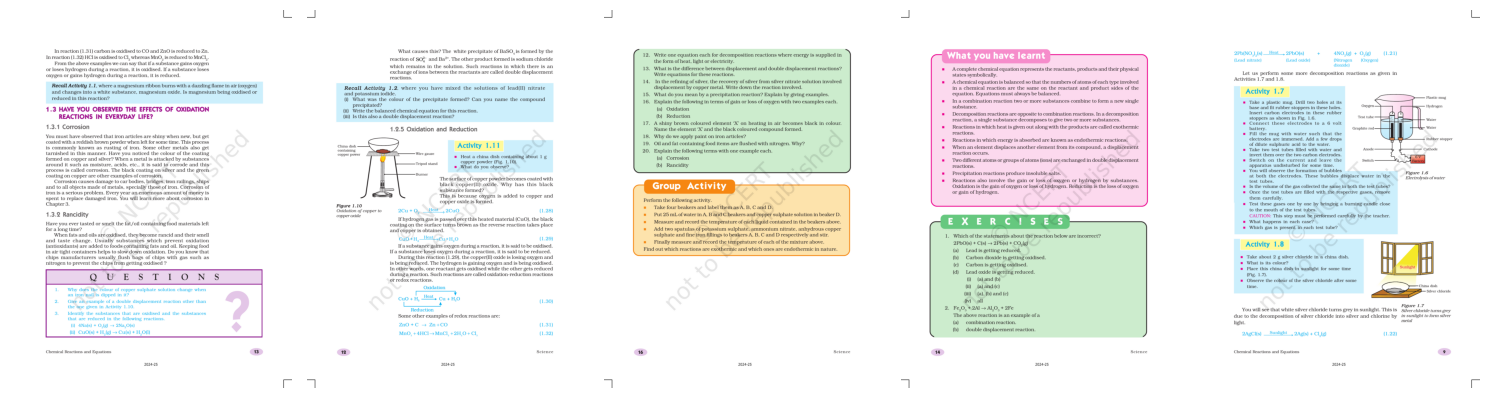

In [18]:
display_image_grid(matched_images)

In [19]:
def read_and_encode_image(image_path: str):

    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()
        
    image_format = Image.open(image_path).format.lower()

    message_content = {
                    "image": {
                        "format": image_format,
                        "source": {"bytes": image_bytes},
                    }
                }
    
    return message_content


def send_images_to_model_using_converse(matched_items: list, query: str, model_id: str):

    system_prompt = 'You are a helpful assistant for question answering. Given the context, answer the question. Do not include any other text than the answer.'

    image_list = []
    for image_path in matched_items:
        image_list.append({
            "image_path": image_path, 
        })

    content_list = []
    for img in image_list:
        message_content = read_and_encode_image(img['image_path'])
        content_list.append(message_content)
    
    content_list.append({"text": query})
    system = [ { "text": system_prompt } ]
    
    # Define a "user" message including both the image and a text prompt.
    messages = [
        {
            "role": "user",
            "content": content_list,
        }
    ]
    
    # Configure the inference parameters.
    inf_params = {"temperature": .3, "maxTokens": 5000}
    
    # Initialize the Bedrock client
    client = boto3.client('bedrock-runtime', region_name='us-east-1')

    response = client.converse(
        modelId=model_id, 
        messages=messages,
        system=system, 
        inferenceConfig=inf_params
    )
    
    # Print Response
    output_message = response["output"]["message"]["content"][0]["text"]

    return output_message

In [20]:
PRO_MODEL_ID = "amazon.nova-pro-v1:0"
LITE_MODEL_ID = "amazon.nova-lite-v1:0"
MICRO_MODEL_ID = "amazon.nova-micro-v1:0"

response = send_images_to_model_using_converse(matched_items=matched_images_path, query=query_text, model_id=PRO_MODEL_ID)
print(response)

/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/botocore/auth.py:419: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime_now = datetime.datetime.utcnow()


Corrosion and Rancidity


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Use the Knowledge Base with Agents using CrewAI
</h1>

In [21]:
# Initialize CrewAI LLM (Amazon Nova Pro) 
model_id = "us.amazon.nova-pro-v1:0"  
llm = LLM(model=model_id)

# Create a Retrieval Tool 
@tool
def retrieve_from_qdrant(query: str):
    """
    Retrieve the most relevant documents from Qdrant vector database
    based on the given text query.
    
    Args:
        query (str): The user query to search in the knowledge base.
    
    Returns:
        list: List of paths to the matched images.
    """
    global client, COLLECTION_NAME, colpali_processor, colpali_model

    print(f"🔍 Retrieving documents for query: {query}")
    
    with torch.no_grad():
        text_embedding = colpali_processor.process_queries([query]).to(colpali_model.device)  
        text_embedding = colpali_model(**text_embedding)

    token_query = text_embedding[0].cpu().float().numpy().tolist()
    start_time = time.time()

    # Perform search in Qdrant
    query_result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=token_query,
        limit=5,
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                ignore=True,
                rescore=True,
                oversampling=2.0
            )
        )
    )

    print(f"⏳ Query Time: {(time.time()-start_time):.3f} s")

    matched_images_path = []

    # Define a folder to save matched images
    MATCHED_IMAGES_DIR = "matched_images"
    
    # Delete all files and the directory itself if it exists
    if os.path.exists(MATCHED_IMAGES_DIR):
        shutil.rmtree(MATCHED_IMAGES_DIR)

    os.makedirs(MATCHED_IMAGES_DIR)
    
    for result in query_result.points:
        doc_id = result.payload["doc_id"]
        page_num = result.payload["page_num"]

        for item in dataset:
            if item["doc_id"] == doc_id and item["page_num"] == page_num:
                image_filename = os.path.join("matched_images", f"match_doc_{doc_id}_page_{page_num}.png")
                item["image"].save(image_filename, "PNG")
                matched_images_path.append(image_filename)

                print(f"✅ Saved: {image_filename}")
                break  

    print("\n📂 All matched images are saved in the 'matched_images' folder.")
    
    return matched_images_path


/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/crewai_tools/tools/base_tool.py:93: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  for arg, attribute in self.args_schema.schema()["properties"].items():


In [22]:
# Define the Retrieval Agent 
retrieval_agent = Agent(
    role="Knowledge Retriever",
    goal="Retrieve the most relevant textbook pages from the knowledge base based on the student’s question.",
    backstory="An intelligent academic assistant trained with NCERT Class X Science. It specializes in pinpointing the most relevant content based on the student’s question and the subject it pertains to.",
    tools=[retrieve_from_qdrant],
    allow_delegation=False,
    verbose=True,
    llm=llm
)

# Define the Multimodal Answering Agent (Strictly image-based)
answering_agent = Agent(
    role="Multimodal Knowledge Expert",
    goal="Accurately interpret the provided images and extract relevant information to answer the question: {query_text}.",
    backstory="An advanced AI specialized in multimodal reasoning, capable of analyzing both text and images to provide the most precise and insightful answers.",
    multimodal=True,
    allow_delegation=False,
    verbose=True,
    llm=llm
)

# Define the Tasks 
retrieval_task = Task(
    description="Retrieve the most relevant images from the knowledge base based on the given query.",
    agent=retrieval_agent,
    expected_output="A list of image file paths related to the query."
)

answering_task = Task(
    description="Using the retrieved images at {{matched_images_path}}, generate a precise answer to the query: {{query_text}}.",
    agent=answering_agent,  # Assign answering agent
    expected_output="A clear and well-structured explanation based on the extracted information from the images. No need to include reference to the images in the answer.",
)


# Assemble the Crew 
crew = Crew(
    agents=[retrieval_agent, answering_agent],
    tasks=[retrieval_task, answering_task],  
    process=Process.sequential,
    verbose=False
)


/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return self.args_schema.schema()["properties"]
/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return self.args_schema.schema()["properties"]


In [23]:
#  Run the Query 
query_text = "What is the correct way of heating the boiling tube containing crystals of ferrous sulphate and of smelling the odour"
result = crew.kickoff(inputs={"query_text": query_text})

# Agent: Knowledge Retriever
## Task: Retrieve the most relevant images from the knowledge base based on the given query.


/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return self.args_schema.schema()["properties"]
/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/langchain_core/tools/structured.py:54: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return self.args_schema.schema()["properties"]
/opt/anaconda3/envs/rag_env/lib/python3.12/site-packages/crewai/tools/tool_usage.py:162: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration

🔍 Retrieving documents for query: NCERT Class X Science images
⏳ Query Time: 0.036 s
✅ Saved: matched_images/match_doc_0_page_9.png
✅ Saved: matched_images/match_doc_0_page_13.png
✅ Saved: matched_images/match_doc_0_page_15.png
✅ Saved: matched_images/match_doc_0_page_5.png
✅ Saved: matched_images/match_doc_0_page_7.png

📂 All matched images are saved in the 'matched_images' folder.


# Agent: Knowledge Retriever
## Thought: Thought: I need to retrieve the most relevant images from the knowledge base based on the given query. I will use the `retrieve_from_qdrant` tool to find the relevant documents.
## Using tool: retrieve_from_qdrant
## Tool Input: 
"{\"query\": \"NCERT Class X Science images\"}"
## Tool Output: 
['matched_images/match_doc_0_page_9.png', 'matched_images/match_doc_0_page_13.png', 'matched_images/match_doc_0_page_15.png', 'matched_images/match_doc_0_page_5.png', 'matched_images/match_doc_0_page_7.png']


# Agent: Knowledge Retriever
## Final Answer: 
['matched_images/ma

In [24]:
# Print the result
Markdown(result.raw)

When heating a boiling tube containing crystals of ferrous sulphate, it is important to follow specific safety and procedural guidelines to ensure accurate results and prevent accidents. Here is the correct way of heating the boiling tube and smelling the odour:

1. **Setup and Preparation:**
   - Place the boiling tube on a stable and heat-resistant surface, such as a wire gauze supported by a tripod stand.
   - Use a Bunsen burner or another appropriate heat source to provide a controlled flame.

2. **Heating Procedure:**
   - Gently heat the boiling tube by moving the flame under the tube, ensuring even distribution of heat. Avoid direct and concentrated heating on one spot to prevent the tube from cracking.
   - As the ferrous sulphate crystals begin to heat, observe the changes. Ferrous sulphate heptahydrate (FeSO₄·7H₂O) will initially lose its water of crystallization, turning from green to a white powder.

3. **Observation of Reactions:**
   - Continue heating until the substance further decomposes. You may notice the formation of sulphur dioxide (SO₂) and sulphur trioxide (SO₃) gases, along with iron(III) oxide (Fe₂O₃).
   - The characteristic odours associated with these gases will start to become noticeable.

4. **Smelling the Odour:**
   - To safely smell the odour produced, **never** bring your nose directly over the boiling tube. This is unsafe and can lead to inhalation of harmful gases.
   - Instead, gently waft the air above the boiling tube towards your nose using a hand or a piece of paper. This allows you to detect the odour without directly inhaling the gases.
   - The odour of sulphur dioxide is sharp and irritating, often described as similar to the smell of a just-struck match.

5. **Safety Precautions:**
   - Wear appropriate personal protective equipment (PPE), including safety goggles and gloves, to protect yourself from splashes and fumes.
   - Conduct the experiment in a well-ventilated area, preferably under a fume hood, to avoid the accumulation of harmful gases.

By following these steps, you can safely heat ferrous sulphate crystals in a boiling tube and correctly identify the odours produced during the decomposition process.